In [49]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
file_path = 'M02_Feb_2021_OP13_000.csv'
# file_path = 'machine_status.csv'
df = pd.read_csv(file_path)
# df = df.drop(columns=['Unnamed: 4', 'Unnamed: 5'])

In [51]:
df.head()

,x,y,z,status
0,-3,23,-1030,1
1,9,-19,-1036,1
2,13,31,-1024,1
3,-560,-156,-854,0
4,-573,-158,-827,0


In [52]:
display(df.shape)
display(df.size)

(96518, 4)

386072

In [53]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96518 entries, 0 to 96517
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       96518 non-null  int64
 1   y       96518 non-null  int64
 2   z       96518 non-null  int64
 3   status  96518 non-null  int64
dtypes: int64(4)
memory usage: 2.9 MB


In [54]:
df.describe().style.background_gradient(cmap="magma")

,x,y,z,status
count,96518.000000,96518.000000,96518.000000,96518.000000
mean,8.437784,7.188659,-1038.274415,0.668207
std,400.492180,265.498926,312.030155,0.470860
min,-2043.000000,-2299.000000,-2920.000000,0.000000
25%,-21.000000,-68.000000,-1126.000000,0.000000
50%,7.000000,9.000000,-1032.000000,1.000000
75%,35.000000,81.000000,-950.000000,1.000000
max,2178.000000,2178.000000,868.000000,1.000000


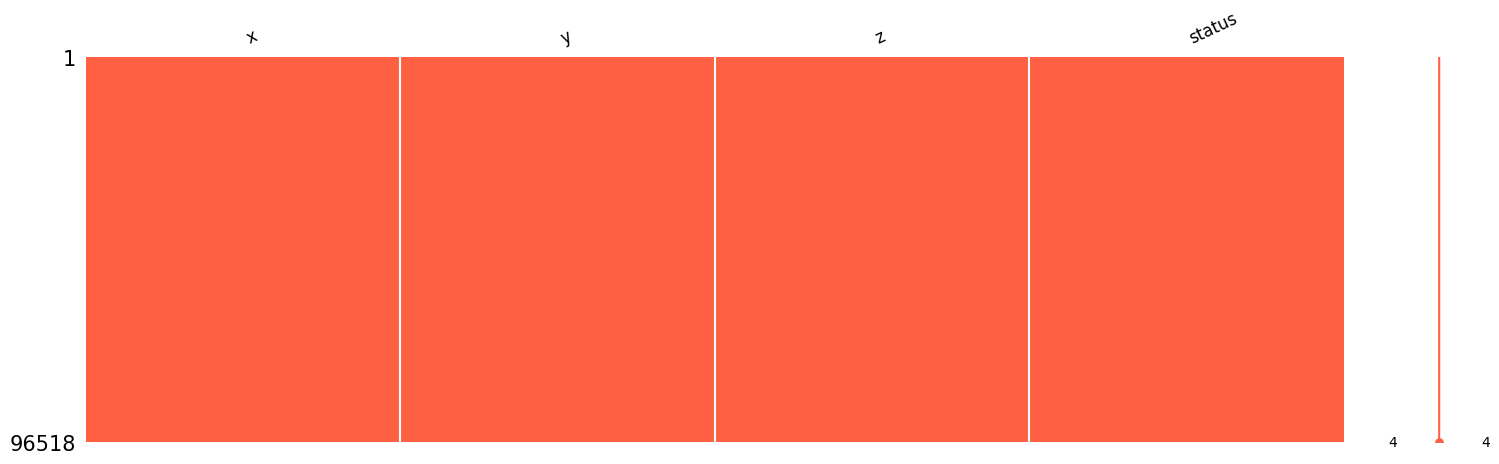

In [55]:
import missingno as msno
msno.matrix(df, figsize=(18,5), fontsize=12, color=(1, 0.38, 0.27));
plt.xticks(rotation=25);

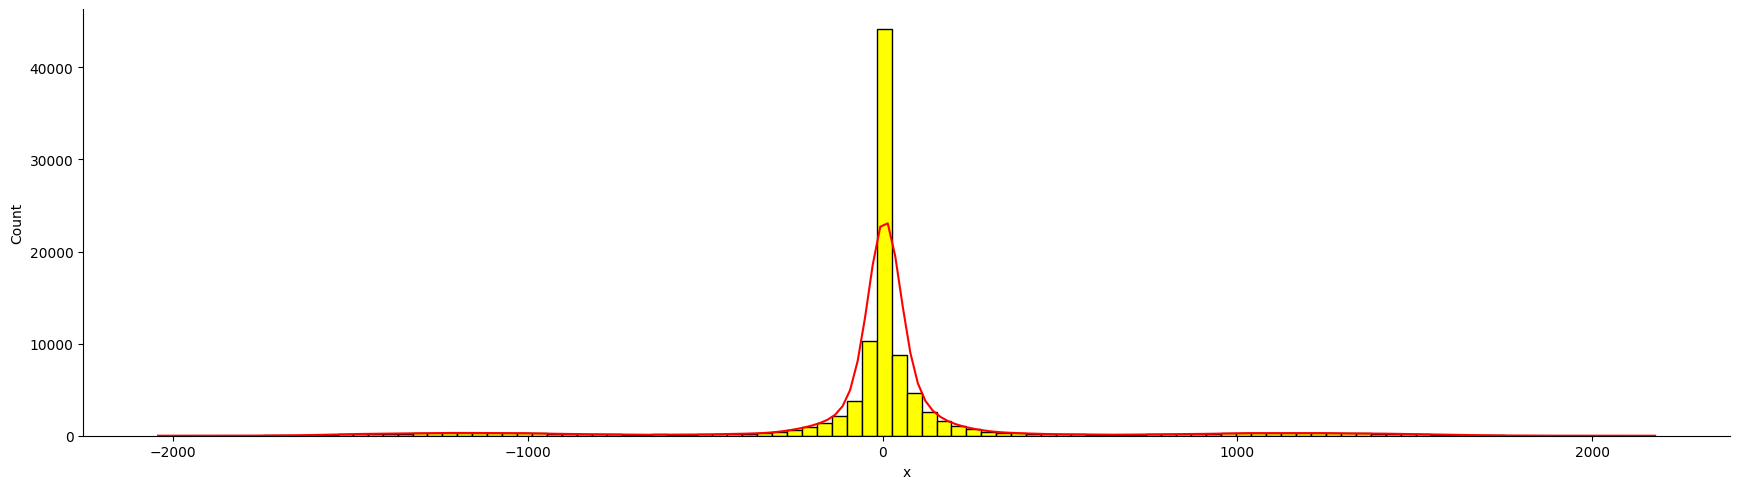

In [56]:
sns.displot(data=df, x="x", kde=True, bins = 100, color = "red", facecolor = "yellow",height = 5, aspect = 3.5);

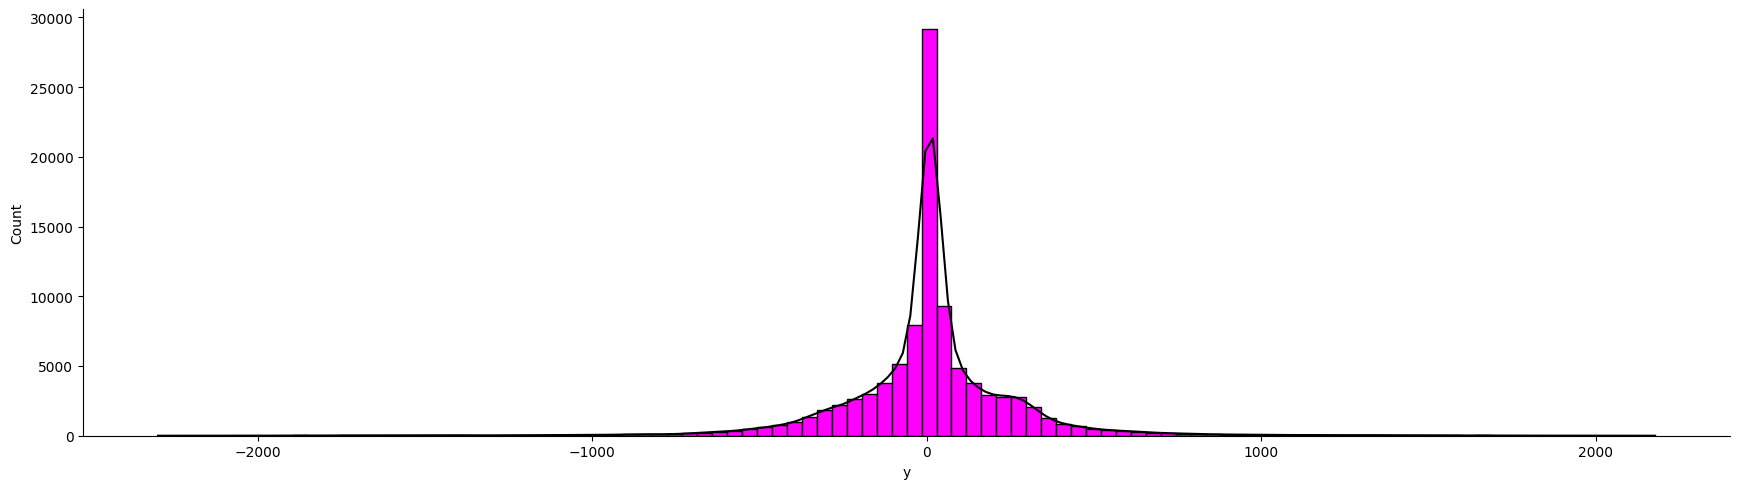

In [57]:
sns.displot(data=df, x="y", kde=True, bins = 100,color = "black", facecolor = "magenta",height = 5, aspect = 3.5);

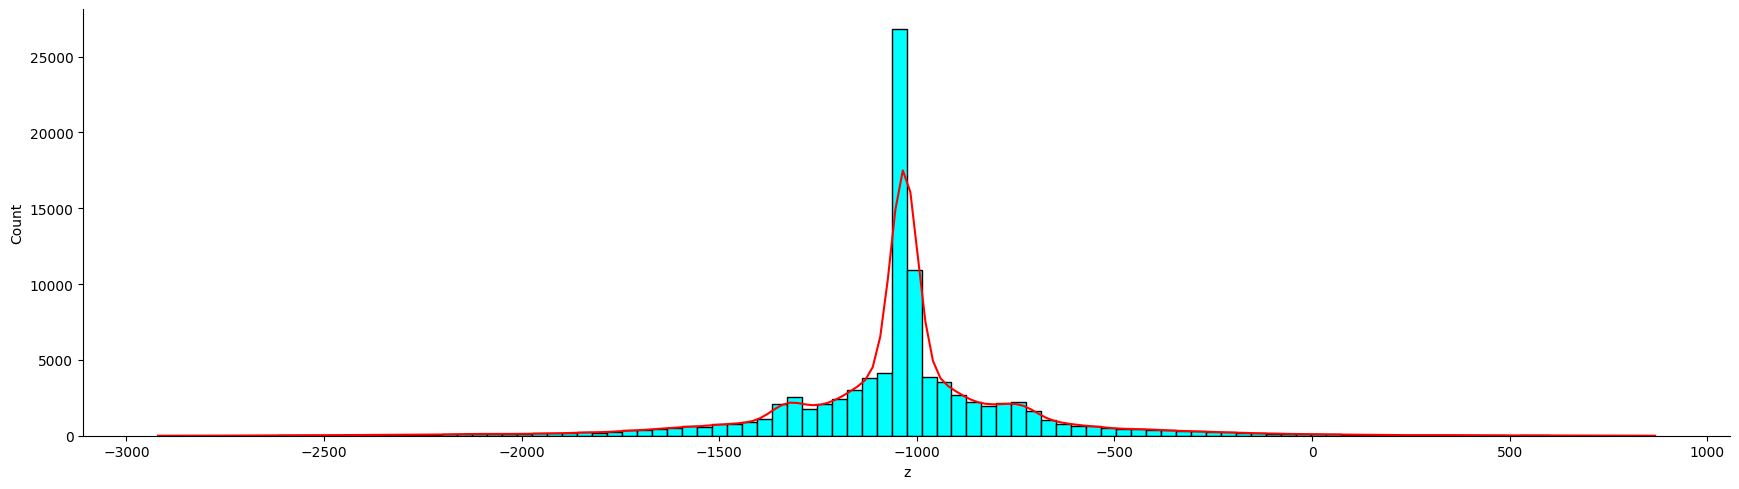

In [58]:
sns.displot(data=df, x="z", kde=True, bins = 100,color = "red", facecolor = "cyan",height = 5, aspect = 3.5);

Text(0.5, 1.0, 'status')

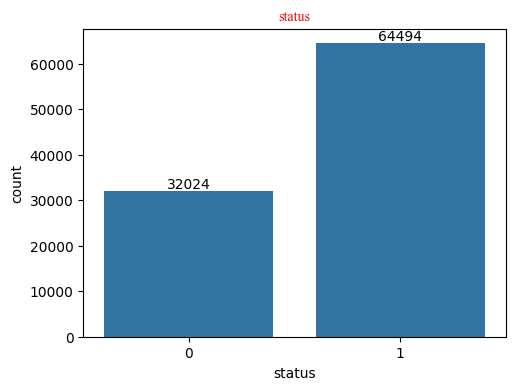

In [59]:
ax = plt.figure(figsize=(12,4))
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='status', data=df)
ax.bar_label(ax.containers[0])
plt.title("status", fontsize=20,color='Red',font='Times New Roman')

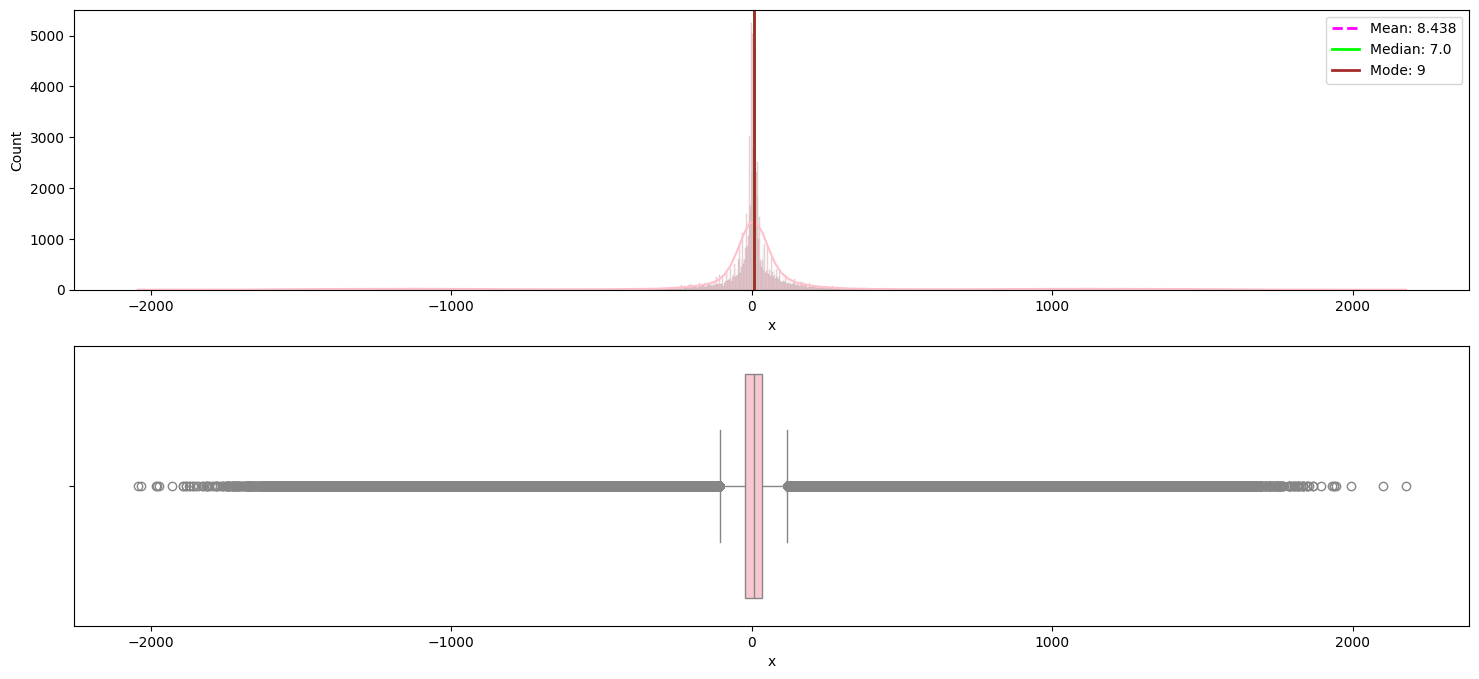

In [60]:
import statistics

def plot_hist(feature):
    fig, ax = plt.subplots(2, 1, figsize=(18, 8))
    
    sns.histplot(data = df[feature], kde = True, ax = ax[0],color='pink')

    ax[0].axvline(x = df[feature].mean(), color = 'Magenta', linestyle = '--', linewidth = 2, label = 'Mean: {}'.format(round(df[feature].mean(), 3)))
    ax[0].axvline(x = df[feature].median(), color = 'lime', linewidth = 2, label = 'Median: {}'.format(round(df[feature].median(), 3)))
    ax[0].axvline(x = statistics.mode(df[feature]), color = 'brown', linewidth = 2, label = 'Mode: {}'.format(statistics.mode(df[feature])))
    ax[0].legend()
    
    sns.boxplot(x = df[feature], ax = ax[1],color='pink')
    
    plt.show()

plot_hist('x')

In [61]:
# plot_hist('y')

In [62]:
# plot_hist('z')

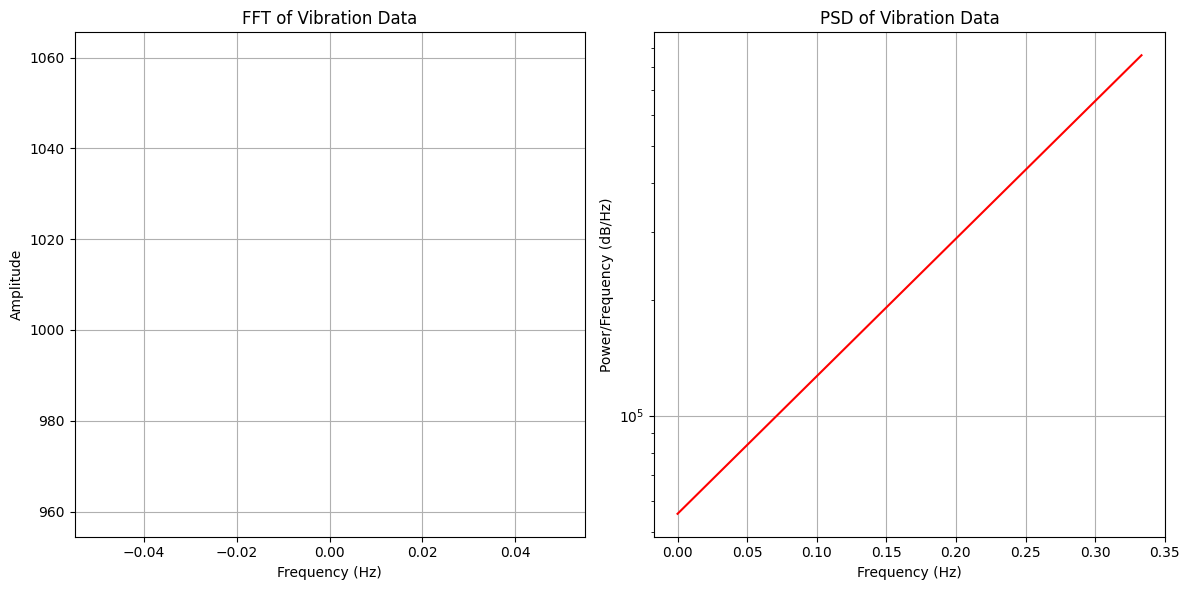

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import welch



# Extract vibration data (x, y, z)
X = df[['x', 'y', 'z']].values

# Choose an example row (let's say the first instance of your data)
sample = X[0]

# Apply FFT to x, y, z axes
X_fft = np.abs(fft(sample))

# Use only the first half of FFT as before
X_fft_half = X_fft[:len(X_fft) // 2]

# Compute frequencies for FFT
frequencies = np.fft.fftfreq(len(sample))[:len(X_fft_half)]

# Compute PSD using Welch's method
freqs_psd, psd = welch(sample, nperseg=len(sample))

# Plot FFT and PSD
plt.figure(figsize=(12, 6))

# FFT plot
plt.subplot(1, 2, 1)
plt.plot(frequencies, X_fft_half, label='FFT')
plt.title('FFT of Vibration Data')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)

# PSD plot
plt.subplot(1, 2, 2)
plt.semilogy(freqs_psd, psd, label='PSD', color='r')  # semilogy for better PSD visualization
plt.title('PSD of Vibration Data')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)

plt.tight_layout()
plt.show()


In [64]:
import numpy as np
from scipy.signal import find_peaks

# Function to calculate harmonic features
def calculate_harmonics(freqs, psd, num_harmonics=5):
    # Find fundamental frequency (the peak with the highest magnitude)
    fundamental_freq = freqs[np.argmax(psd)]
    
    harmonics_amplitude = []
    harmonics_energy = []

    for i in range(1, num_harmonics + 1):
        harmonic_freq = i * fundamental_freq
        # Find the closest frequency in the spectrum to this harmonic
        idx = (np.abs(freqs - harmonic_freq)).argmin()
        
        # Amplitude and energy of the harmonic
        harmonics_amplitude.append(psd[idx])
        harmonics_energy.append(psd[idx] ** 2)
    
    # Sum energy of all harmonics
    total_harmonic_energy = np.sum(harmonics_energy)
    
    return harmonics_amplitude, total_harmonic_energy






In [65]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from scipy.fft import fft
from scipy.signal import welch  # For PSD calculation
from scipy.stats import skew, kurtosis  # For skewness and kurtosis

X = df[['x', 'y', 'z']].values
y = df['status'].values

# Apply FFT to x, y, z axes
X_fft = np.abs(fft(X, axis=1))
X_fft = X_fft[:, :X_fft.shape[1] // 2]  # Use only the first half of FFT

# Feature engineering: Calculate additional frequency domain and statistical features
def feature_engineering(X_fft, X):
    features = []
    for i, row in enumerate(X_fft):
        # FFT Features
        dominant_freq = np.argmax(row)  # Index of the dominant frequency
        avg_freq = np.mean(row)         # Average of frequency components
        freq_energy = np.sum(row ** 2)  # Energy in frequency domain (sum of squares)

        # PSD Features using Welch's method
        freqs, psd = welch(X[i], nperseg=len(X[i]))  # Compute PSD
        psd_mean = np.mean(psd)  # Mean of PSD
        psd_peak = np.max(psd)   # Peak of PSD

        harmonics_amplitude, total_harmonic_energy = calculate_harmonics(freqs, psd)

        # Statistical Features (in time domain)
        skewness = skew(X[i])                # Skewness of the time-domain signal
        kurt = kurtosis(X[i])                # Kurtosis of the time-domain signal
        rms = np.sqrt(np.mean(X[i] ** 2))    # RMS of the time-domain signal
        peak_to_peak = np.max(X[i]) - np.min(X[i])
        crest_factor = np.max(np.abs(X[i])) / np.sqrt(np.mean(X[i] ** 2))

        # Collect all features
        features.append([dominant_freq, avg_freq, freq_energy, psd_mean, psd_peak, skewness, kurt, rms,
                         *harmonics_amplitude, total_harmonic_energy,peak_to_peak,crest_factor])
    
    return np.array(features)

# Add FFT, PSD, and statistical features to the dataset
X_features = feature_engineering(X_fft, X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)




RandomForestClassifier(random_state=42)

In [66]:
# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')

random_forest_train = round(clf.score(X_train, y_train) * 100, 2)
random_forest_accuracy = round(accuracy_score(y_pred, y_test) * 100, 2)

print("Training Accuracy    :",random_forest_train ,"%")
print("Model Accuracy Score :",random_forest_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

Accuracy: 0.8505
Training Accuracy    : 99.92 %
Model Accuracy Score : 85.05 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.79      0.75      0.77      6392
           1       0.88      0.90      0.89     12912

    accuracy                           0.85     19304
   macro avg       0.83      0.83      0.83     19304
weighted avg       0.85      0.85      0.85     19304

--------------------------------------------------------


In [67]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay

# X = df.drop(columns="status" , axis=1)
# y = df["status"]

# from sklearn.model_selection import train_test_split
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=21)

# random_forest = RandomForestClassifier(n_estimators=100)
# random_forest.fit(X_train, y_train)
# y_pred_rf = random_forest.predict(X_test)
# random_forest.score(X_train, y_train)

# random_forest_train = round(random_forest.score(X_train, y_train) * 100, 2)
# random_forest_accuracy = round(accuracy_score(y_pred_rf, y_test) * 100, 2)

# print("Training Accuracy    :",random_forest_train ,"%")
# print("Model Accuracy Score :",random_forest_accuracy ,"%")
# print("\033[1m--------------------------------------------------------\033[0m")
# print("Classification_Report: \n",classification_report(y_test,y_pred_rf))
# print("\033[1m--------------------------------------------------------\033[0m")
# cm = confusion_matrix(y_test, y_pred_rf)

# # Display the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_forest.classes_)
# disp.plot(cmap='Blues')

In [68]:
# cross_check = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred_rf})
# cross_check

In [69]:
# import joblib

# joblib.dump(clf, 'model_rffft_2.joblib')

In [70]:
# loaded_model = joblib.load('model_rf_1.joblib')
# y_pred = loaded_model.predict(X_test)


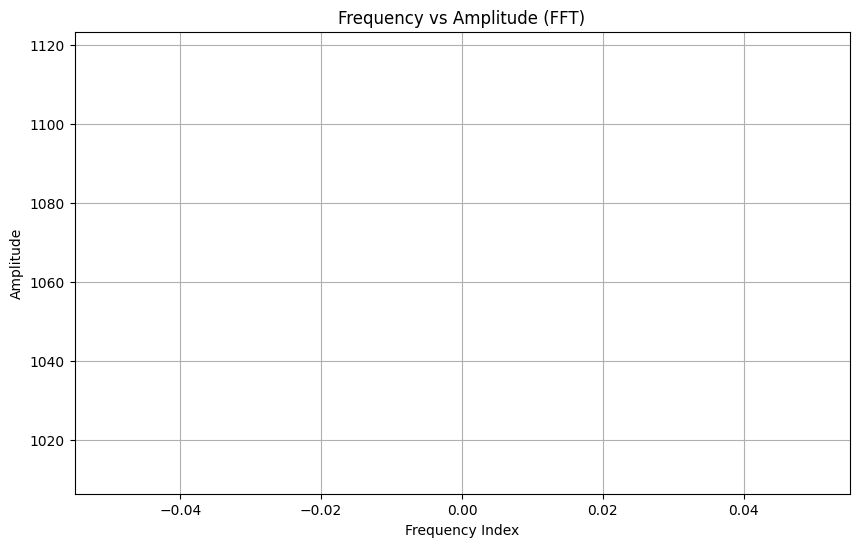

NameError: name 'freqs' is not defined

<Figure size 1000x600 with 0 Axes>

In [71]:
import matplotlib.pyplot as plt

# Plot 1: Frequency vs Amplitude (FFT results)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(X_fft.shape[1]), np.mean(X_fft, axis=0))
plt.title('Frequency vs Amplitude (FFT)')
plt.xlabel('Frequency Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Plot 2: Harmonics vs Frequency
def calculate_harmonics(freqs, psd):
    # Simplified: Find harmonic peaks (here using top 5)
    harmonic_indices = np.argsort(psd)[-5:]
    harmonics_amplitude = psd[harmonic_indices]
    total_harmonic_energy = np.sum(harmonics_amplitude)
    return harmonics_amplitude, total_harmonic_energy

# Assuming calculate_harmonics has already been applied during feature extraction
plt.figure(figsize=(10, 6))
plt.stem(freqs[harmonic_indices], harmonics_amplitude)
plt.title('Harmonics Amplitude vs Frequency')
plt.xlabel('Frequency')
plt.ylabel('Harmonic Amplitude')
plt.grid(True)
plt.show()

# Plot 3: PSD (Power Spectral Density)
plt.figure(figsize=(10, 6))
plt.semilogy(freqs, np.mean([welch(X[i], nperseg=len(X[i]))[1] for i in range(X.shape[0])], axis=0))
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (Power/Frequency)')
plt.grid(True)
plt.show()

# Plot 4: Time domain feature example (RMS vs Peak-to-Peak)
rms_vals = np.sqrt(np.mean(X**2, axis=1))
peak_to_peak_vals = np.ptp(X, axis=1)

plt.figure(figsize=(10, 6))
plt.scatter(rms_vals, peak_to_peak_vals, alpha=0.7)
plt.title('RMS vs Peak-to-Peak in Time Domain')
plt.xlabel('RMS')
plt.ylabel('Peak-to-Peak')
plt.grid(True)
plt.show()


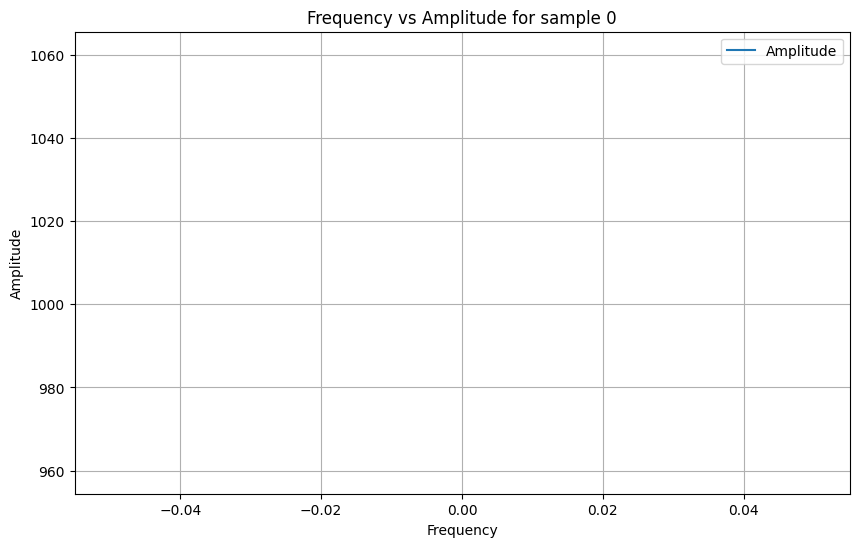

NameError: name 'freqs' is not defined

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot frequency vs amplitude (FFT result)
def plot_freq_vs_amplitude(X_fft, idx=0):
    plt.figure(figsize=(10, 6))
    plt.plot(X_fft[idx], label='Amplitude')
    plt.title(f'Frequency vs Amplitude for sample {idx}')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot harmonics vs frequency using PSD from Welch's method
def plot_harmonics_vs_frequency(freqs, psd, idx=0):
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, psd[idx], label='PSD')
    plt.title(f'Harmonics vs Frequency for sample {idx}')
    plt.xlabel('Frequency')
    plt.ylabel('Power Spectral Density (PSD)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot statistical features (RMS, skewness, kurtosis) comparison
def plot_statistical_features(features, idx=0):
    feature_labels = ['Skewness', 'Kurtosis', 'RMS', 'Peak-to-Peak', 'Crest Factor']
    feature_values = features[idx, -5:]  # last 5 features in the array are statistical

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_labels, y=feature_values)
    plt.title(f'Statistical Features for sample {idx}')
    plt.ylabel('Values')
    plt.show()

# Assuming you already have calculated freqs, psd for plotting
plot_freq_vs_amplitude(X_fft, idx=0)  # plot for first sample
plot_harmonics_vs_frequency(freqs, psd, idx=0)  # plot for first sample's harmonics
plot_statistical_features(X_features, idx=0)  # plot statistical features for the first sample


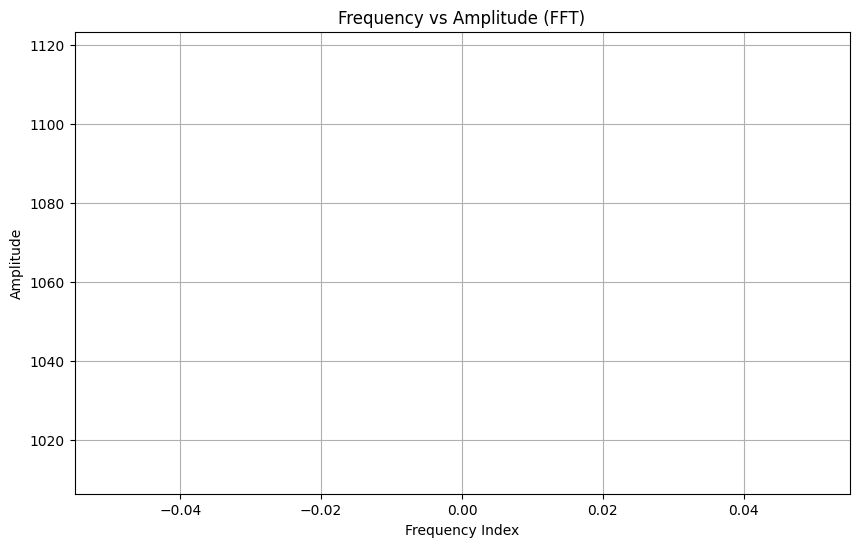

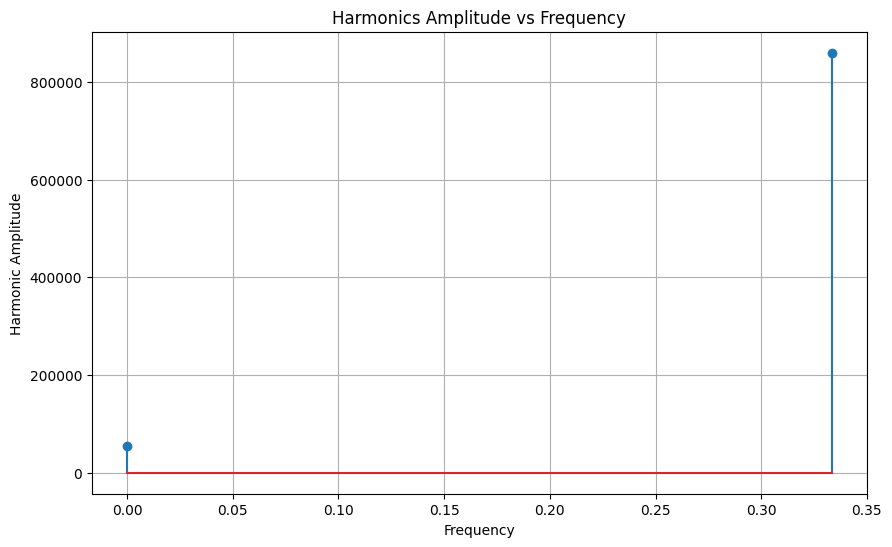

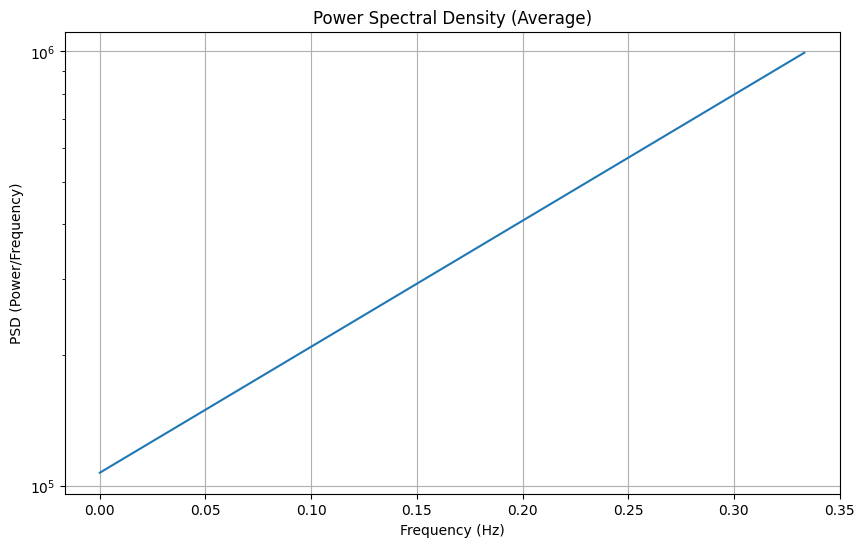

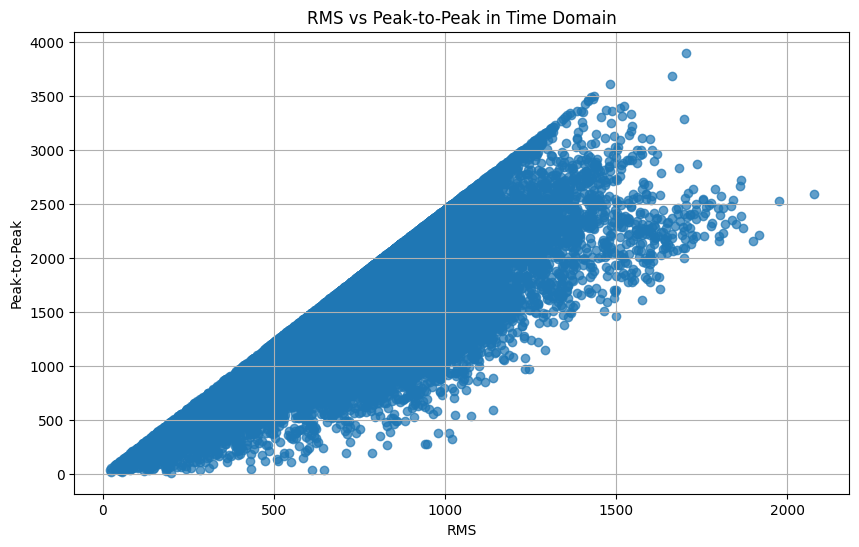

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch

# Assuming df is already defined and data is available

# Apply FFT to x, y, z axes
X_fft = np.abs(fft(X, axis=1))
X_fft = X_fft[:, :X_fft.shape[1] // 2]  # Use only the first half of FFT

# Feature engineering: Calculate additional frequency domain and statistical features
def feature_engineering(X_fft, X):
    features = []
    psd_collection = []
    for i, row in enumerate(X_fft):
        # FFT Features
        dominant_freq = np.argmax(row)  # Index of the dominant frequency
        avg_freq = np.mean(row)         # Average of frequency components
        freq_energy = np.sum(row ** 2)  # Energy in frequency domain (sum of squares)

        # PSD Features using Welch's method
        freqs, psd = welch(X[i], nperseg=len(X[i]))  # Compute PSD
        psd_collection.append(psd)
        psd_mean = np.mean(psd)  # Mean of PSD
        psd_peak = np.max(psd)   # Peak of PSD

        harmonics_amplitude, total_harmonic_energy = calculate_harmonics(freqs, psd)

        # Statistical Features (in time domain)
        skewness = skew(X[i])                # Skewness of the time-domain signal
        kurt = kurtosis(X[i])                # Kurtosis of the time-domain signal
        rms = np.sqrt(np.mean(X[i] ** 2))    # RMS of the time-domain signal
        peak_to_peak = np.max(X[i]) - np.min(X[i])
        crest_factor = np.max(np.abs(X[i])) / np.sqrt(np.mean(X[i] ** 2))

        # Collect all features
        features.append([dominant_freq, avg_freq, freq_energy, psd_mean, psd_peak, skewness, kurt, rms,
                         *harmonics_amplitude, total_harmonic_energy, peak_to_peak, crest_factor])
    
    return np.array(features), freqs, psd_collection

# Call the feature engineering function
X_features, freqs, psd_collection = feature_engineering(X_fft, X)

# Plot the graphs
# Plot 1: Frequency vs Amplitude (FFT results)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(X_fft.shape[1]), np.mean(X_fft, axis=0))
plt.title('Frequency vs Amplitude (FFT)')
plt.xlabel('Frequency Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Plot 2: Harmonics vs Frequency
harmonic_indices = np.argsort(psd_collection[0])[-5:]  # Top 5 harmonic peaks from the first sample
harmonics_amplitude = psd_collection[0][harmonic_indices]  # Using the first sample's PSD for illustration

plt.figure(figsize=(10, 6))
plt.stem(freqs[harmonic_indices], harmonics_amplitude)
plt.title('Harmonics Amplitude vs Frequency')
plt.xlabel('Frequency')
plt.ylabel('Harmonic Amplitude')
plt.grid(True)
plt.show()

# Plot 3: PSD (Power Spectral Density)
plt.figure(figsize=(10, 6))
plt.semilogy(freqs, np.mean(psd_collection, axis=0))  # Averaged PSD over all samples
plt.title('Power Spectral Density (Average)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (Power/Frequency)')
plt.grid(True)
plt.show()

# Plot 4: Time domain feature example (RMS vs Peak-to-Peak)
rms_vals = np.sqrt(np.mean(X**2, axis=1))
peak_to_peak_vals = np.ptp(X, axis=1)

plt.figure(figsize=(10, 6))
plt.scatter(rms_vals, peak_to_peak_vals, alpha=0.7)
plt.title('RMS vs Peak-to-Peak in Time Domain')
plt.xlabel('RMS')
plt.ylabel('Peak-to-Peak')
plt.grid(True)
plt.show()
